In [1]:
# default_exp prices

In [44]:
#exports
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import mplfinance as mpf
import FEAutils as hlp

import os
import requests

In [3]:
import dotenv
from IPython.display import JSON

In [4]:
dotenv.load_dotenv()
api_key = os.getenv('QUANDL_API_KEY')

In [5]:
#exports
def get_ets_mkt_data(
    api_key, 
    api_root='https://www.quandl.com/api/v3/datasets', 
    quandl_code='CHRIS/ICE_C1'
):
    # Constructing endpoint
    endpoint_url = f'{api_root}/{quandl_code}.json'

    # Making the data request
    params = {'api_key': api_key}
    r = requests.get(endpoint_url, params=params)

    # Converting to a dataframe
    dataset = r.json()['dataset']
    df = pd.DataFrame(dataset['data'], columns=dataset['column_names'])

    # Cleaning the dataframe
    df.columns = df.columns.str.lower().str.replace('.', '').str.replace(' ', '_')
    df = df.rename(columns={'date': 'datetime'}).set_index('datetime')
    df['close'] = df['open'] + df['change']
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    
    return df

In [6]:
%%time

df_ets = get_ets_mkt_data(api_key)

df_ets.head()

Wall time: 1.58 s


C:\Users\Ayrto\anaconda3\envs\ETSWatch\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.


,open,high,low,settle,change,wave,volume,prev_day_open_interest,efp_volume,efs_volume,block_volume,close
datetime,,,,,,,,,,,,
2008-04-08,24.87,24.87,24.87,24.87,24.87,NaN,NaN,0.0,NaN,NaN,NaN,49.74
2008-04-09,25.05,25.05,25.05,25.05,0.18,NaN,NaN,0.0,NaN,NaN,NaN,25.23
2008-04-10,25.79,25.79,25.79,25.79,0.74,NaN,NaN,0.0,NaN,NaN,NaN,26.53
2008-04-11,25.70,25.70,25.70,25.70,-0.09,NaN,NaN,0.0,NaN,NaN,NaN,25.61
2008-04-14,26.34,26.34,26.34,26.34,0.64,NaN,NaN,0.0,NaN,NaN,NaN,26.98


<br>

### Visualisations

In this section we'll visualise the data we've just downloaded, starting with a full temporal resolution line-plot of the time-series

In [7]:
#exports
def plot_long_term_avg(df):
    fig, ax = plt.subplots(dpi=250, figsize=(10, 4))

    df['settle'].plot(ax=ax, color='#AE0019', linewidth=1)

    ax.set_ylim(0)
    ax.set_xlim(df.index.min(), df.index.max())
    ax.set_xlabel('')
    ax.set_ylabel('Price (EUR/tonne CO2)')
    hlp.hide_spines(ax)
    
    return fig, ax

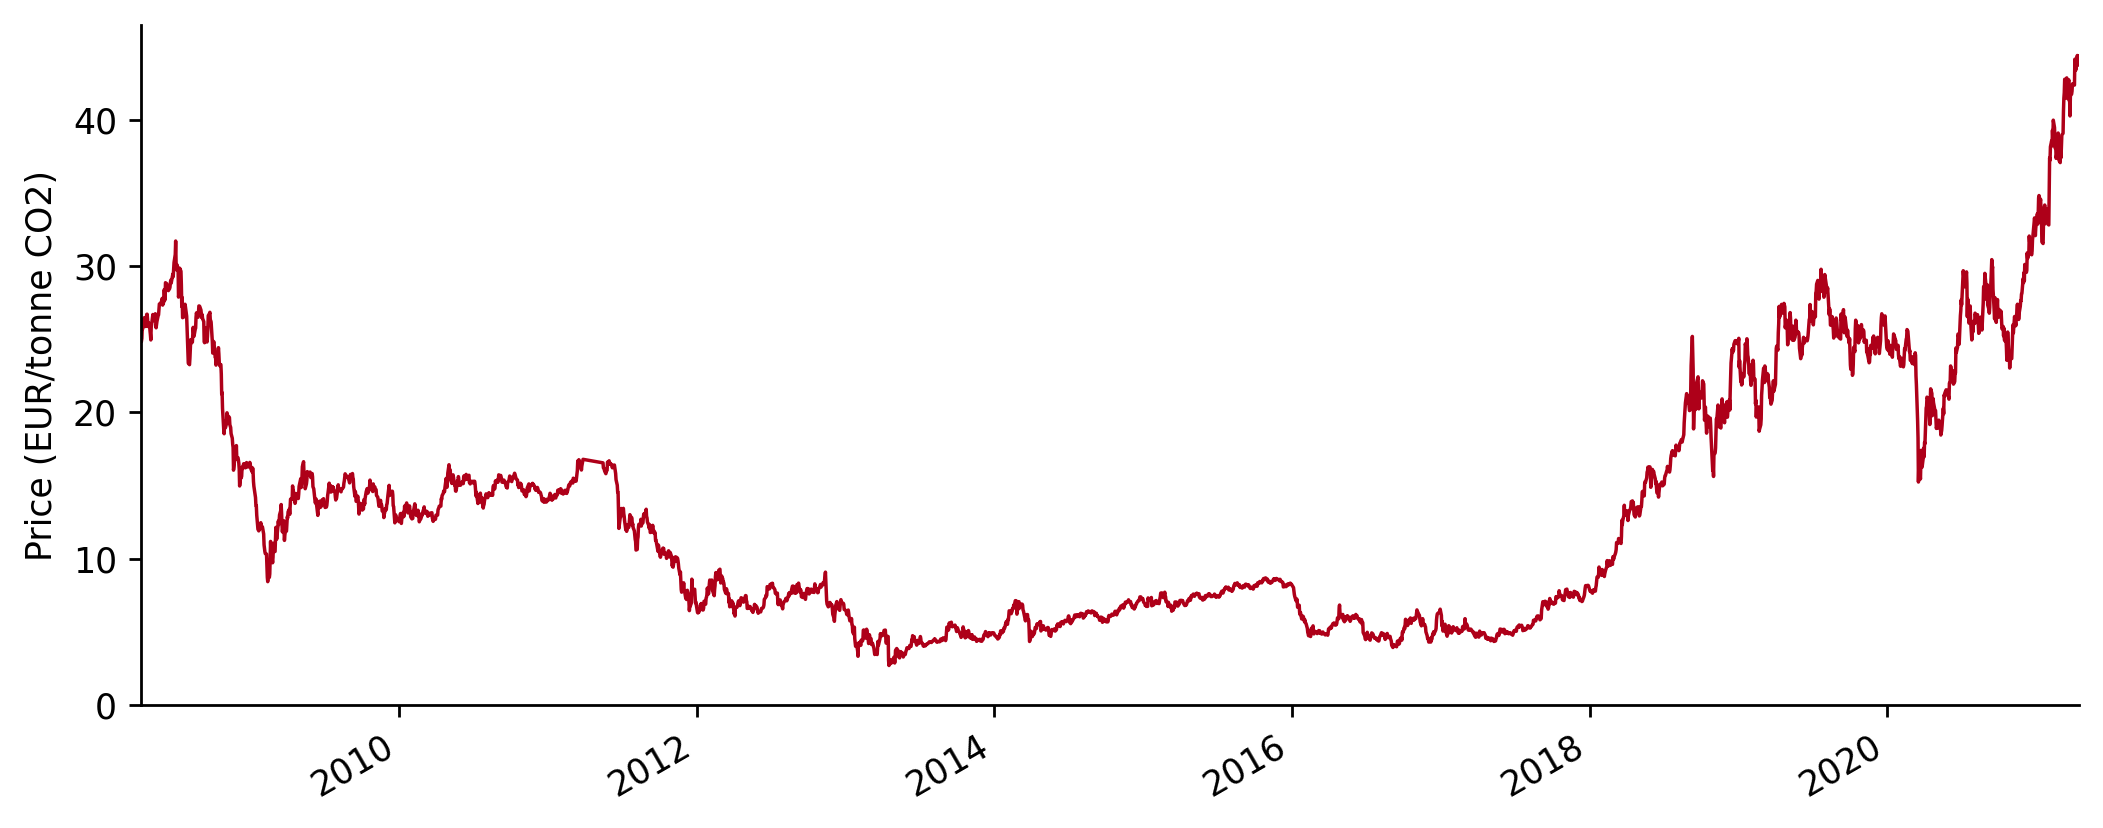

In [8]:
fig, ax = plot_long_term_avg(df_ets)

<br>

We'll also create a slightly richer graphic for the most recent data, combining a candle-stick chart with the volume

In [9]:
#exports
def plot_ohlc_vol(df):
    fig, axs = plt.subplots(dpi=250, nrows=2, figsize=(8, 8))

    mpf.plot(df, type='candle', ax=axs[0], volume=axs[1], show_nontrading=True, style='sas')

    ax = axs[0]
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_ylabel('Price (EUR/tonne CO2)')
    ax.yaxis.set_label_position('left')
    ax.yaxis.tick_left()
    hlp.hide_spines(ax, positions=['top', 'bottom', 'right'])

    ax = axs[1]
    ax.set_ylabel('Volume (tonne CO2)')
    hlp.hide_spines(ax, positions=['top', 'right'])
    
    return fig, axs

def plot_recent_ohlc_vol(df, weeks=8, latest_date=None):
    if latest_date is None:
        latest_date = df.index.max()
        
    earliest_date = latest_date - pd.Timedelta(weeks=weeks)

    cols = ['open', 'high', 'low', 'close', 'volume']
    df_recent = df[cols].sort_index().dropna().loc[earliest_date:latest_date]
    
    fig, axs = plot_ohlc_vol(df_recent)
    
    return fig, axs

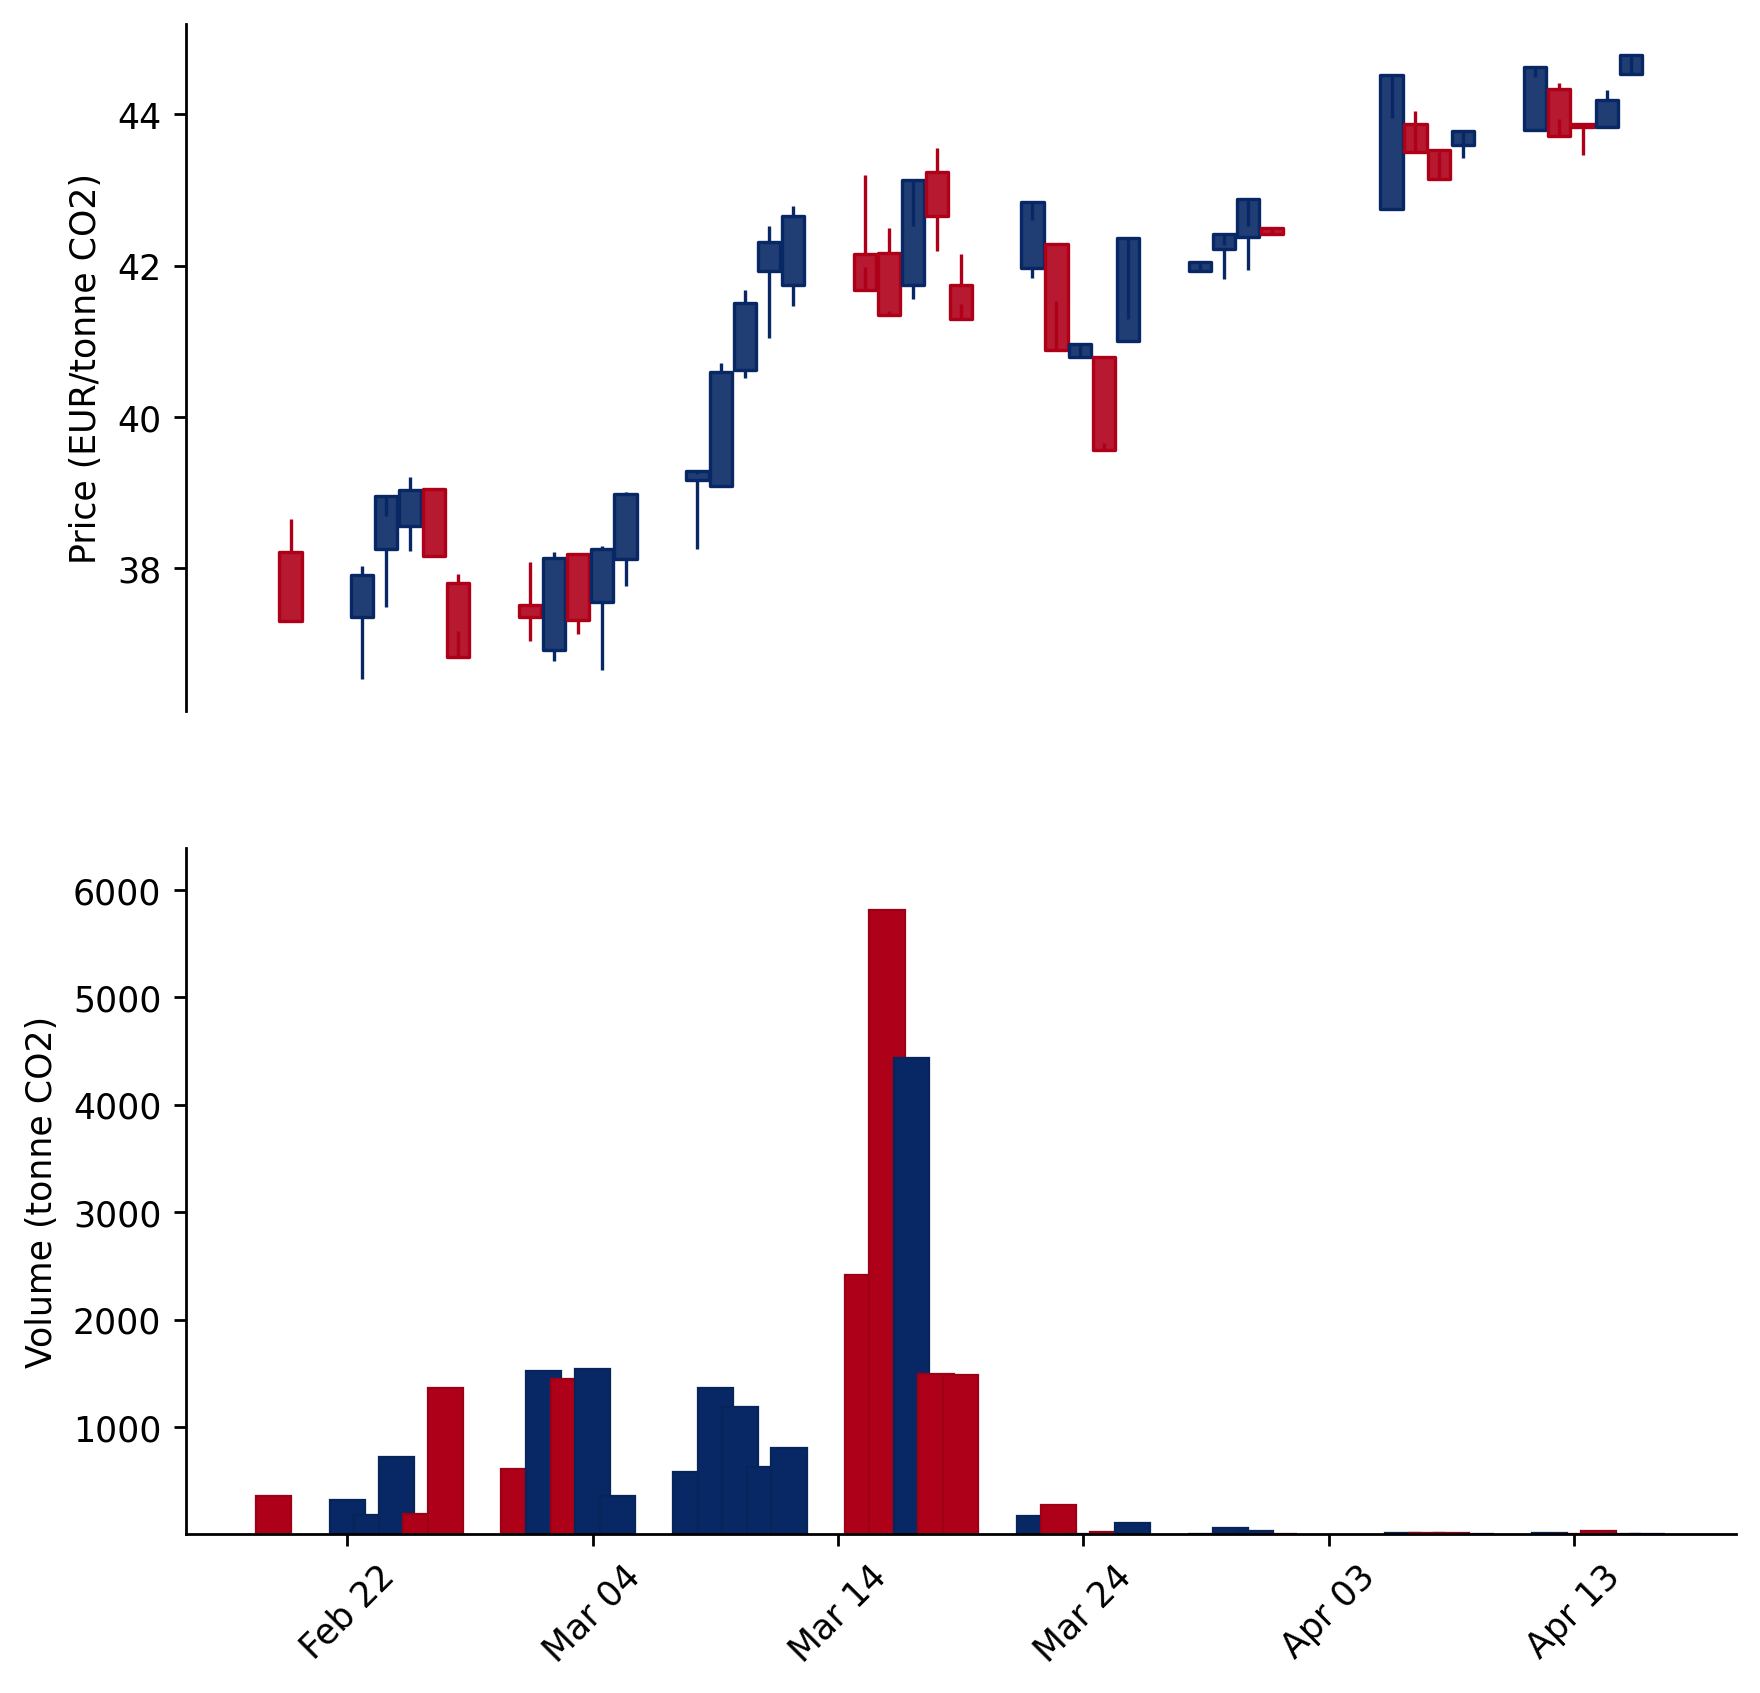

In [10]:
fig, axs = plot_recent_ohlc_vol(df_ets)

<br>

The ETS market has some interesting quirks, including a quite distinct annual cycle

Text(0, 0.5, 'Average Daily Volume (tonne CO2)')

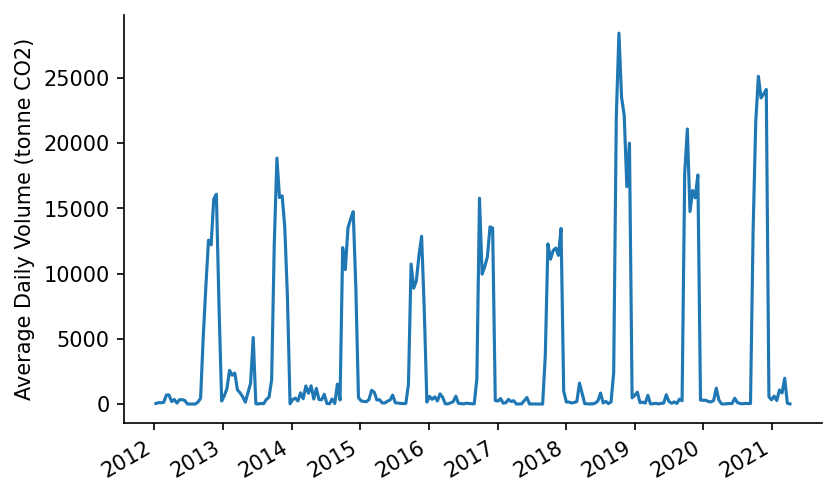

In [11]:
fig, ax = plt.subplots(dpi=150)

df_ets['volume'].resample('14D').mean().dropna()['2012':].plot(ax=ax)

hlp.hide_spines(ax)
ax.set_xlabel('')
ax.set_ylabel('Average Daily Volume (tonne CO2)')

<br>

Let's average the daily volume based on the day of the year

Text(0, 0.5, 'Daily Volume (tonne CO2)')

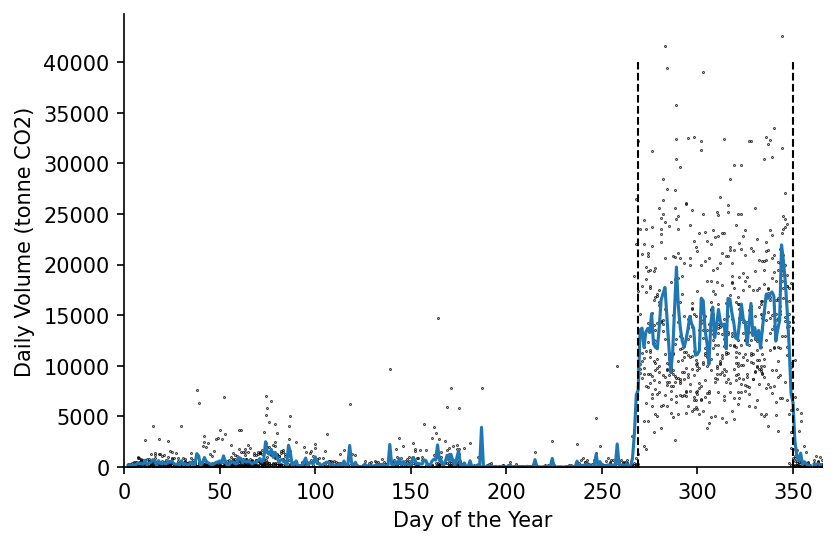

In [220]:
high_vol_start_day = 269
high_vol_end_day = 350

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(df_ets.index.dayofyear, df_ets['volume'], s=0.1, color='k')
df_ets['volume'].groupby(df_ets.index.dayofyear).mean().plot()
plt.plot([high_vol_start_day, high_vol_start_day], [0, 40000], 'k--', linewidth=1)
plt.plot([high_vol_end_day, high_vol_end_day], [0, 40000], 'k--', linewidth=1)

hlp.hide_spines(ax)
ax.set_xlim(0, 365)
ax.set_ylim(0)
ax.set_xlabel('Day of the Year')
ax.set_ylabel('Daily Volume (tonne CO2)')

<br>

### Probabilistic Volume Model (by Day of Year)

Lets try and quantify how the 

In [19]:
# !pip install moepy

In [21]:
from moepy import lowess

In [221]:
# Seperating x/y
x = df_ets['volume'].dropna().index.dayofyear.values
y = df_ets['volume'].dropna().values

# Estimating the quantiles
df_quantiles = lowess.quantile_model(x,
                                     y,
                                     frac=0.2, num_fits=40)

# Cleaning names and sorting for plotting
df_quantiles.columns = [f'p{int(col*100)}' for col in df_quantiles.columns]
df_quantiles = df_quantiles[df_quantiles.columns[::-1]]

df_quantiles.head()

 [████████████████████████████████████████████████████████████] 9/9 [00:16<00:02, 1.80s/it]

C:\Users\Ayrto\AppData\Roaming\Python\Python37\site-packages\moepy\lowess.py:239: RuntimeWarning: invalid value encountered in true_divide
  loading_weights = loading_weights/loading_weights.sum(axis=0) # normalising


,p90,p80,p70,p60,p50,p40,p30,p20,p10
x,,,,,,,,,
2,608.992347,538.841411,399.170510,280.131072,227.268455,165.520184,110.911733,67.295193,35.413783
3,627.071210,540.296679,399.755384,281.064441,226.541257,164.641698,110.398541,66.923932,35.172402
4,644.750029,541.350122,400.051579,281.828480,225.748151,163.726408,109.856979,66.544992,34.930467
5,662.065030,541.709934,399.837702,282.467070,224.895380,162.767508,109.280811,66.151805,34.685745
6,679.035811,541.182091,398.965030,283.008216,223.986491,161.760443,108.665853,65.740020,34.436730


Text(0, 0.5, 'Average Daily Volume (tonne CO2)')

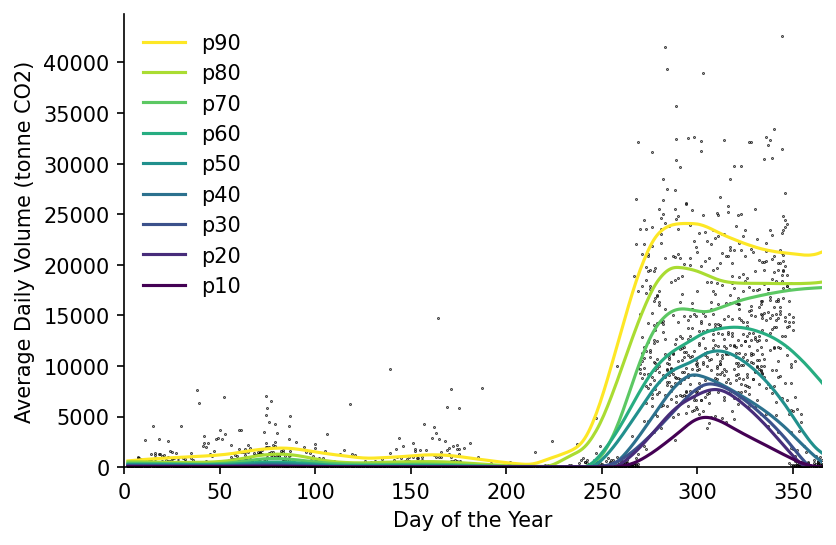

In [222]:
fig, ax = plt.subplots(dpi=150)

ax.scatter(x, y, s=0.1, color='k')
df_quantiles.plot(ax=ax, cmap='viridis_r')

hlp.hide_spines(ax)
ax.legend(frameon=False)
ax.set_xlim(0, 365)
ax.set_ylim(0)
ax.set_xlabel('Day of the Year')
ax.set_ylabel('Average Daily Volume (tonne CO2)')

In [223]:
df_bootstrap = (lowess
                .bootstrap_model(x, 
                                 y, 
                                 num_runs=100, 
                                 frac=0.2, 
                                 num_fits=10, 
                                 q=0.5, 
                                 model=lowess.Lowess(lowess.calc_quant_reg_betas)
                                )
                .sort_index()
                .drop_duplicates()
               )

df_bootstrap.head()

 [████████████████████████████████████████████████████████████] 100/100 [00:49<00:00, 0.49s/it]

C:\Users\Ayrto\AppData\Roaming\Python\Python37\site-packages\moepy\lowess.py:239: RuntimeWarning: invalid value encountered in true_divide
  loading_weights = loading_weights/loading_weights.sum(axis=0) # normalising


bootstrap_run,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
x,,,,,,,,,,,,,,,,,,,,,
2,171.405368,259.720051,244.045499,230.850127,140.111100,180.634676,228.999862,204.451031,231.767367,236.800060,...,147.212806,207.000037,216.292804,245.181776,179.605382,149.709805,220.555632,188.285725,228.999969,182.357157
3,171.837802,258.760050,242.522752,229.900087,142.888881,180.000018,228.346043,204.725504,230.511554,235.000054,...,149.000042,204.333369,216.146460,243.090870,180.000115,149.838833,218.277853,189.571438,228.617593,183.000012
4,172.270236,257.800049,241.000006,228.950046,145.666661,179.365360,227.692224,204.999976,229.255742,233.200049,...,150.787278,201.666701,216.000116,240.999963,180.394849,149.967862,216.000074,190.857151,228.235217,183.642868
5,172.702671,256.840047,239.477259,228.000006,148.444442,178.730703,227.038405,205.274448,227.999929,231.400043,...,152.574514,199.000033,215.853772,238.909056,180.789583,150.096891,213.722296,192.142864,227.852842,184.285724
6,173.135105,255.880046,237.954512,227.049966,151.222223,178.096045,226.384586,205.548920,226.744117,229.600037,...,154.361751,196.333364,215.707427,236.818150,181.184316,150.225919,211.444517,193.428577,227.470466,184.928580


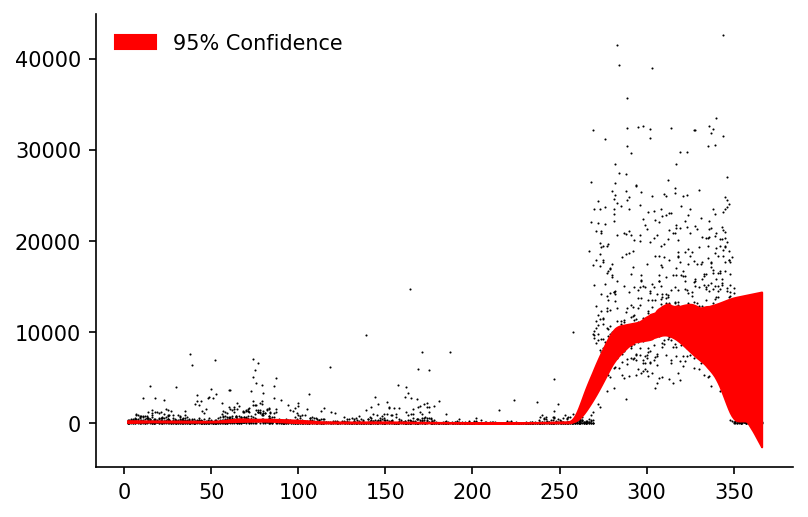

In [224]:
df_conf_intvl = lowess.get_confidence_interval(df_bootstrap, conf_pct=0.95)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(x, y, color='k', linewidth=0, s=1, zorder=1)
ax.fill_between(df_conf_intvl.index, df_conf_intvl['min'], df_conf_intvl['max'], color='r', alpha=1, label='95% Confidence')

ax.legend(frameon=False)
hlp.hide_spines(ax)

<br>

It's clear that the model is far less confident in its predictions in the later months, largely driven by the step change seen after day ~265 which continues until day ~355

In [225]:
high_vol_days_mask = (x>high_vol_start_day) & (x<high_vol_end_day)

high_vol_days_mask

array([False, False, False, ..., False, False, False])

In [226]:
df_bootstrap_high_vol = (lowess
                         .bootstrap_model(x[high_vol_days_mask], 
                                          y[high_vol_days_mask], 
                                          num_runs=250, 
                                          frac=0.6, 
                                          num_fits=10, 
                                          q=0.5,
                                          bag_size=0.8,
                                          model=lowess.Lowess(lowess.calc_quant_reg_betas)
                                         )
                         .sort_index()
                         .drop_duplicates()
                        )

df_bootstrap_high_vol.head()

 [████████████████████████████████████████████████████████████] 250/250 [01:32<00:00, 0.37s/it]

bootstrap_run,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
x,,,,,,,,,,,,,,,,,,,,,
270,10977.518918,10608.871980,11699.781792,11560.447208,10346.937793,10716.689350,10602.285953,10492.171098,10785.798101,11310.720197,...,10442.360624,11776.977280,11669.322622,12560.114244,12016.752279,12014.401818,10886.132249,11342.104953,10103.102517,10611.326692
271,11018.148303,10644.706502,11670.484252,11601.453979,10405.460052,10756.570071,10638.134426,10534.322587,10822.469417,11337.571049,...,10481.009417,11821.163340,11719.699382,12597.008665,12061.335470,12057.372951,10924.677753,11384.083820,10140.495602,10647.386267
272,11058.777693,10680.831269,11646.453383,11636.401050,10463.045286,10796.475585,10674.274716,10576.193321,10859.415582,11365.403403,...,10519.658210,11865.296867,11765.549789,12634.793036,12105.914413,12100.476014,10963.419988,11426.062687,10177.888691,10683.717812
273,11099.407089,10717.247177,11627.035046,11665.784883,10519.672011,10836.395063,10710.697107,10617.776697,10896.632392,11394.063152,...,10558.306746,11909.393284,11807.182714,12673.438685,12150.475578,12143.684750,11002.340976,11468.032737,10215.280057,10720.322720
274,11140.036501,10753.712984,11609.985388,11687.740044,10574.983937,10876.468734,10746.705395,10659.005961,10933.626986,11422.861631,...,10596.941523,11953.513337,11843.861627,12712.217835,12194.417586,12185.607978,11041.340899,11509.532837,10252.579329,10757.003781


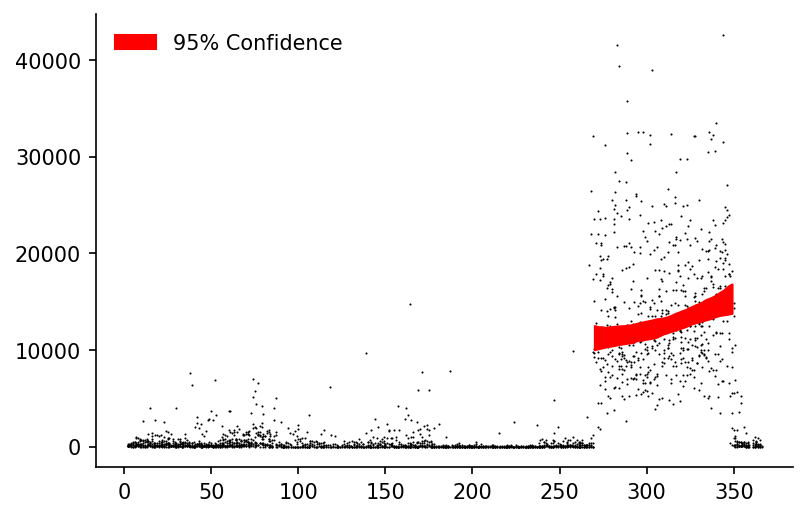

In [227]:
df_conf_intvl = lowess.get_confidence_interval(df_bootstrap_high_vol, conf_pct=0.95)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(x, y, color='k', linewidth=0, s=1, zorder=1)
ax.fill_between(df_conf_intvl.index, df_conf_intvl['min'], df_conf_intvl['max'], color='r', alpha=1, label='95% Confidence')

ax.legend(frameon=False)
hlp.hide_spines(ax)

 [████████████████████████████████████████████████████████████] 9/9 [00:11<00:01, 1.20s/it]

Text(0, 0.5, 'Average Daily Volume (tonne CO2)')

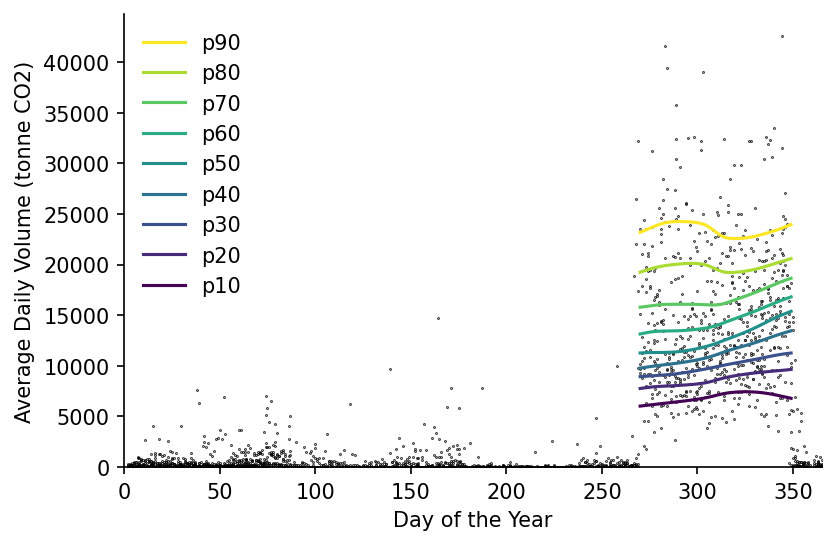

In [228]:
# Estimating the quantiles
df_quantiles_high_vol = lowess.quantile_model(x[high_vol_days_mask],
                                              y[high_vol_days_mask],
                                              frac=0.6, 
                                              num_fits=40
                                             )

# Cleaning names and sorting for plotting
df_quantiles_high_vol.columns = [f'p{int(col*100)}' for col in df_quantiles_high_vol.columns]
df_quantiles_high_vol = df_quantiles_high_vol[df_quantiles_high_vol.columns[::-1]]

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(df_ets.index.dayofyear, df_ets['volume'], s=0.1, color='k')
df_quantiles_high_vol.plot(ax=ax, cmap='viridis_r')

hlp.hide_spines(ax)
ax.legend(frameon=False)
ax.set_xlim(0, 365)
ax.set_ylim(0)
ax.set_xlabel('Day of the Year')
ax.set_ylabel('Average Daily Volume (tonne CO2)')

 [████████████████████████████████████████████████████████████] 9/9 [00:15<00:02, 1.70s/it]

C:\Users\Ayrto\AppData\Roaming\Python\Python37\site-packages\moepy\lowess.py:239: RuntimeWarning: invalid value encountered in true_divide
  loading_weights = loading_weights/loading_weights.sum(axis=0) # normalising


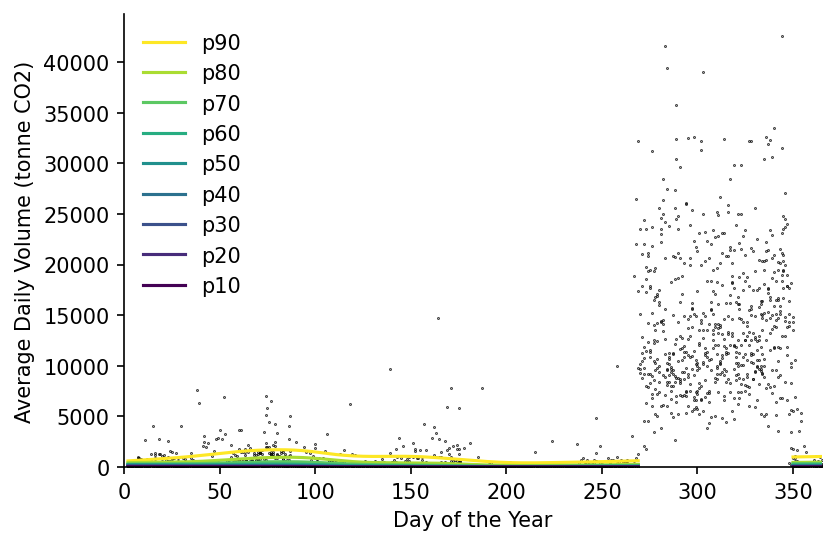

In [229]:
# Estimating the quantiles
df_quantiles_low_vol = lowess.quantile_model(x[~high_vol_days_mask],
                                             y[~high_vol_days_mask],
                                             frac=0.4, 
                                             num_fits=40
                                            )

# Cleaning names and sorting for plotting
df_quantiles_low_vol.columns = [f'p{int(col*100)}' for col in df_quantiles_low_vol.columns]
df_quantiles_low_vol = df_quantiles_low_vol[df_quantiles_low_vol.columns[::-1]]

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(df_ets.index.dayofyear, df_ets['volume'], s=0.1, color='k')
df_quantiles_low_vol.loc[:high_vol_start_day].plot(ax=ax, cmap='viridis_r')
df_quantiles_low_vol.loc[high_vol_end_day:].plot(ax=ax, cmap='viridis_r')

hlp.hide_spines(ax)
ax.set_xlim(0, 365)
ax.set_ylim(0)
ax.set_xlabel('Day of the Year')
ax.set_ylabel('Average Daily Volume (tonne CO2)')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), frameon=False)

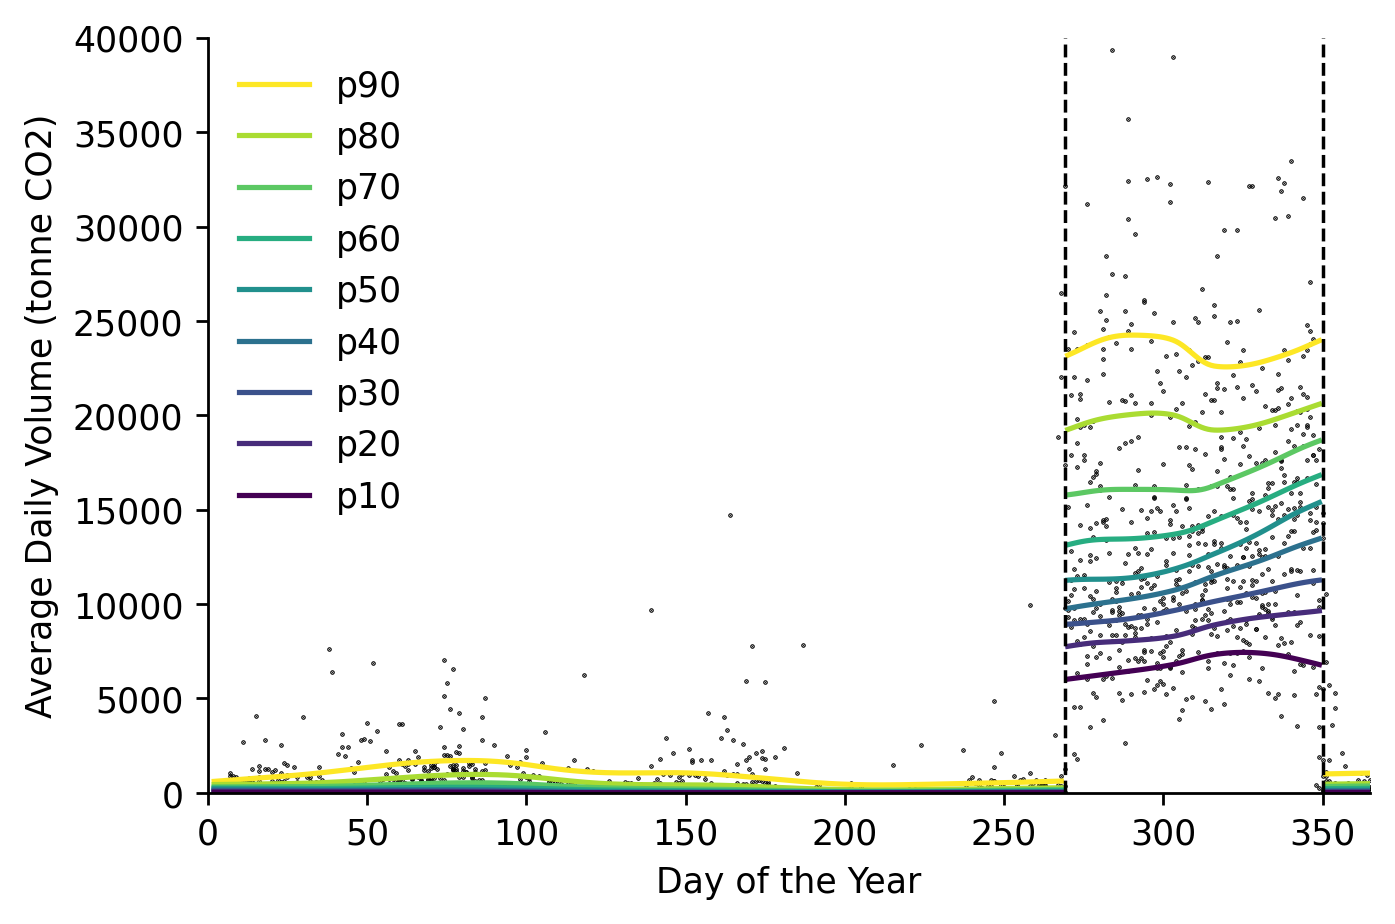

In [230]:
y_max = 40000

# Initialisation
fig, ax = plt.subplots(dpi=250)

# Plots
ax.scatter(df_ets.index.dayofyear, df_ets['volume'], s=0.1, color='k')

df_quantiles_low_vol.loc[:high_vol_start_day-1].plot(ax=ax, cmap='viridis_r', linewidth=1.5)
df_quantiles_low_vol.loc[high_vol_end_day+1:].plot(ax=ax, cmap='viridis_r', linewidth=1.5)
df_quantiles_high_vol.loc[high_vol_start_day:high_vol_end_day].plot(ax=ax, cmap='viridis_r', linewidth=1.5)

plt.plot([high_vol_start_day, high_vol_start_day], [0, y_max], 'k--', linewidth=1)
plt.plot([high_vol_end_day, high_vol_end_day], [0, y_max], 'k--', linewidth=1)

# Cleaning up
hlp.hide_spines(ax)
ax.set_xlim(0, 365)
ax.set_ylim(0, y_max)
ax.set_xlabel('Day of the Year')
ax.set_ylabel('Average Daily Volume (tonne CO2)')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), frameon=False)

In [231]:
# Estimating the low vol quantiles
df_quantiles_low_vol = lowess.quantile_model(x[~high_vol_days_mask],
                                             y[~high_vol_days_mask],
                                             frac=0.4, 
                                             num_fits=40,
                                             qs=[0.16, 0.84]
                                            )

# Cleaning names and sorting for plotting the low vol quantiles
df_quantiles_low_vol.columns = [f'p{int(col*100)}' for col in df_quantiles_low_vol.columns]
df_quantiles_low_vol = df_quantiles_low_vol[df_quantiles_low_vol.columns[::-1]]

# Estimating the high vol quantiles
df_quantiles_high_vol = lowess.quantile_model(x[high_vol_days_mask],
                                              y[high_vol_days_mask],
                                              frac=0.6, 
                                              num_fits=40,
                                             qs=[0.16, 0.84]
                                             )

# Cleaning names and sorting for plotting the high vol quantiles
df_quantiles_high_vol.columns = [f'p{int(col*100)}' for col in df_quantiles_high_vol.columns]
df_quantiles_high_vol = df_quantiles_high_vol[df_quantiles_high_vol.columns[::-1]]

 [████████████████████████████████████████████████████████████] 2/2 [00:03<00:02, 1.66s/it]

C:\Users\Ayrto\AppData\Roaming\Python\Python37\site-packages\moepy\lowess.py:239: RuntimeWarning: invalid value encountered in true_divide
  loading_weights = loading_weights/loading_weights.sum(axis=0) # normalising


 [████████████████████████████████████████████████████████████] 2/2 [00:02<00:01, 1.17s/it]

In [232]:
df_bootstrap_low_vol = (lowess
                        .bootstrap_model(x[~high_vol_days_mask], 
                                         y[~high_vol_days_mask], 
                                         num_runs=250, 
                                         frac=0.6, 
                                         num_fits=10, 
                                         q=0.5,
                                         bag_size=0.8,
                                         model=lowess.Lowess(lowess.calc_quant_reg_betas)
                                        )
                        .sort_index()
                        .drop_duplicates()
                       )

 [████████████████████████████████████████████████████████████] 250/250 [02:01<00:00, 0.48s/it]

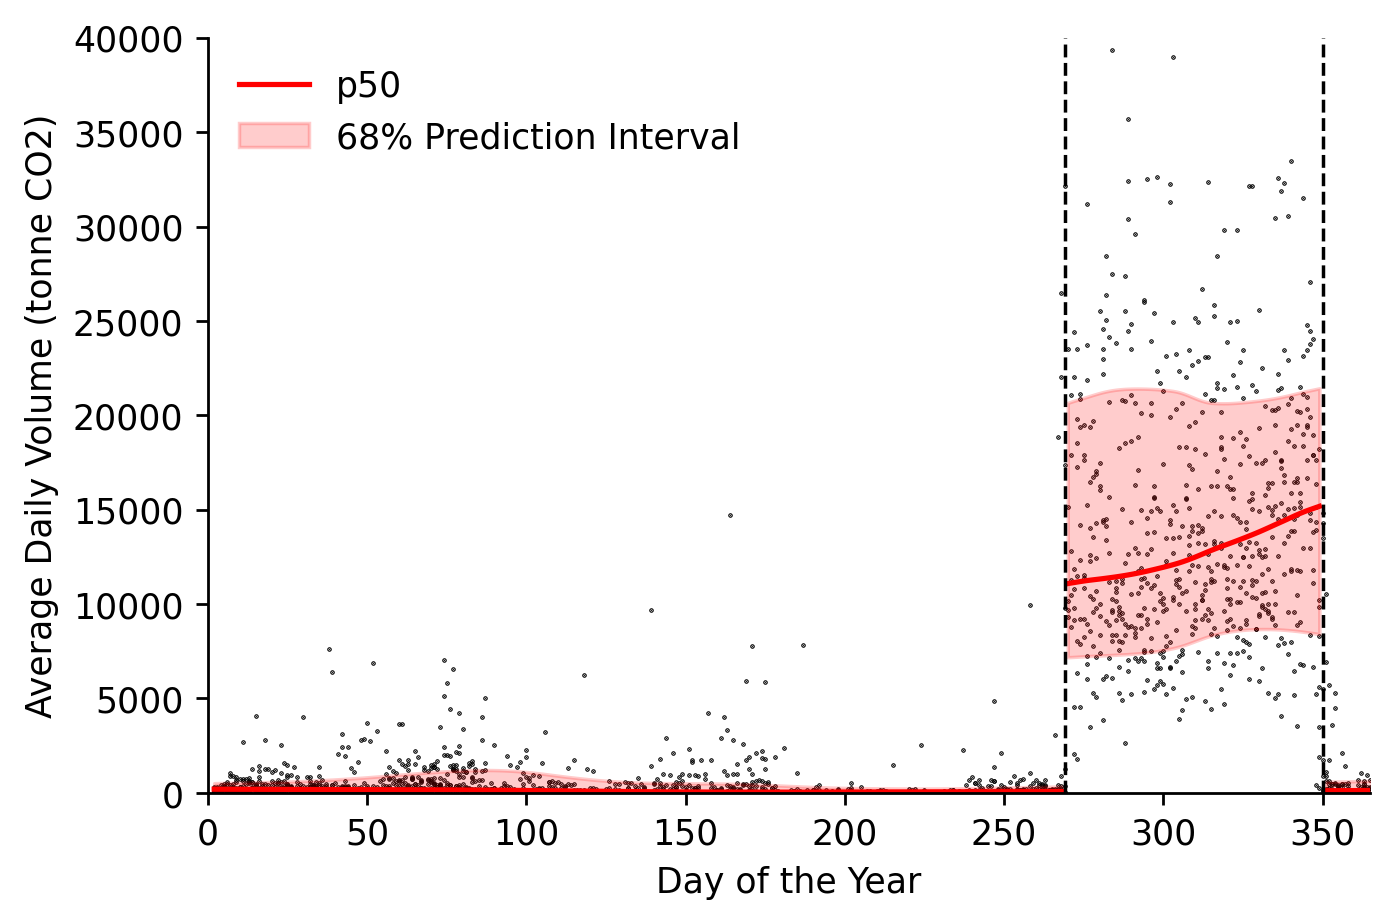

In [233]:
y_max = 40000

# Initialisation
fig, ax = plt.subplots(dpi=250)

# Plots
ax.scatter(df_ets.index.dayofyear, df_ets['volume'], s=0.1, color='k')

df_bootstrap_high_vol.loc[high_vol_start_day:high_vol_end_day].mean(axis=1).plot(color='r', label='p50')
ax.fill_between(df_quantiles_high_vol.index, df_quantiles_high_vol['p16'], df_quantiles_high_vol['p84'], color='r', alpha=0.2, label='68% Prediction Interval')

df_bootstrap_low_vol.loc[:high_vol_start_day-1].mean(axis=1).plot(color='r', label='')
df_bootstrap_low_vol.loc[high_vol_end_day+1:].mean(axis=1).plot(color='r', label='')
ax.fill_between(df_quantiles_low_vol.loc[:high_vol_start_day-1].index, df_quantiles_low_vol.loc[:high_vol_start_day-1, 'p16'], df_quantiles_low_vol.loc[:high_vol_start_day-1, 'p84'], color='r', alpha=0.2, label='')
ax.fill_between(df_quantiles_low_vol.loc[high_vol_end_day+1:].index, df_quantiles_low_vol.loc[high_vol_end_day+1:, 'p16'], df_quantiles_low_vol.loc[high_vol_end_day+1:, 'p84'], color='r', alpha=0.2, label='')

plt.plot([high_vol_start_day, high_vol_start_day], [0, y_max], 'k--', linewidth=1)
plt.plot([high_vol_end_day, high_vol_end_day], [0, y_max], 'k--', linewidth=1)

# Cleaning up
hlp.hide_spines(ax)
ax.set_xlim(0, 365)
ax.set_ylim(0, y_max)
ax.set_xlabel('Day of the Year')
ax.set_ylabel('Average Daily Volume (tonne CO2)')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), frameon=False)

In [265]:
avg_low_vol_std_dev = (df_quantiles_low_vol['p84'] - df_quantiles_low_vol['p16']).mean()
avg_high_vol_std_dev = (df_quantiles_high_vol['p84'] - df_quantiles_high_vol['p16']).mean()

print(f'High Volume Period\nMedian: {int(df_bootstrap_high_vol.mean(axis=1).mean()):,} Tonnes\nStandard Deviation (Equivalent): {int(avg_high_vol_std_dev):,} Tonnes\n')
print(f'Low Volume Period\nMedian: {int(df_bootstrap_low_vol.mean(axis=1).mean()):,} Tonnes\nStandard Deviation (Equivalent): {int(avg_low_vol_std_dev):,} Tonnes')

High Volume Period
Median: 12,728 Tonnes
Standard Deviation (Equivalent): 13,077 Tonnes

Low Volume Period
Median: 97 Tonnes
Standard Deviation (Equivalent): 572 Tonnes


In [266]:
# should add the 95% confidence interval to the above plot
# can keep the 68% prediction interval for the printed stats but remove from the plot

In [13]:
#hide
from nbdev.export import notebook2script
notebook2script('01-mkt-prices.ipynb')

Converted 01-mkt-prices.ipynb.
